In [4]:
# Manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import  warnings
warnings.simplefilter('ignore')

from google.colab import drive
import os

# Configurando tamanho das imagens
rcParams['figure.figsize'] = 15, 6

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [6]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Projeto final
!ls

/content/gdrive/MyDrive/Colab Notebooks/Projeto final
 covid_Brazil.csv   Covid_LSTM.ipynb  'Linear Regression.ipynb'   MLP_covid.ipynb


#### Leitura dos dados

In [7]:
df = pd.read_csv('covid_Brazil.csv', sep=";")
df

,date,target
0,2020-02-26,1
1,2020-02-27,0
2,2020-02-28,0
3,2020-02-29,1
4,2020-03-01,0
...,...,...
602,2021-10-21,16853
603,2021-10-22,14502
604,2021-10-23,11716
605,2021-10-24,6204


150106

In [8]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,target
date,
2020-02-26,1
2020-02-27,0
2020-02-28,0
2020-02-29,1
2020-03-01,0


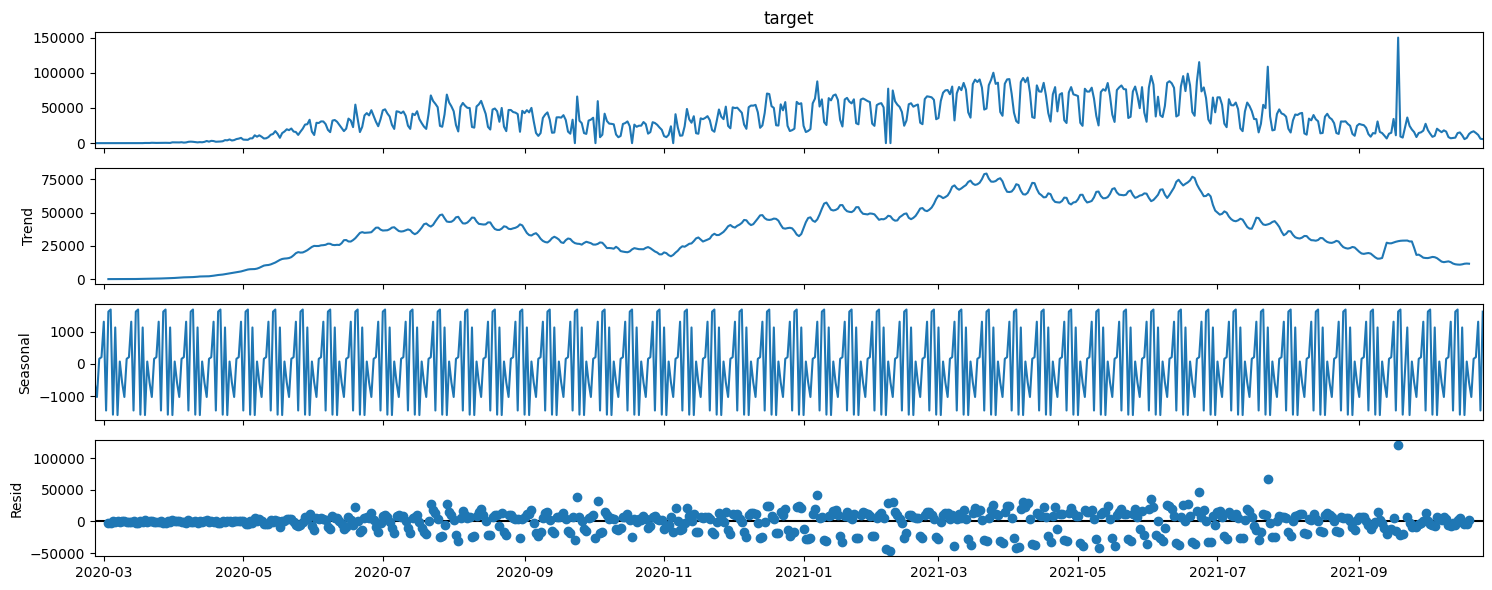

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df['target'], period=12)
decompose.plot();

#### LSTM

#### Pré-processamento

##### Split - Treinamento e teste

455 152


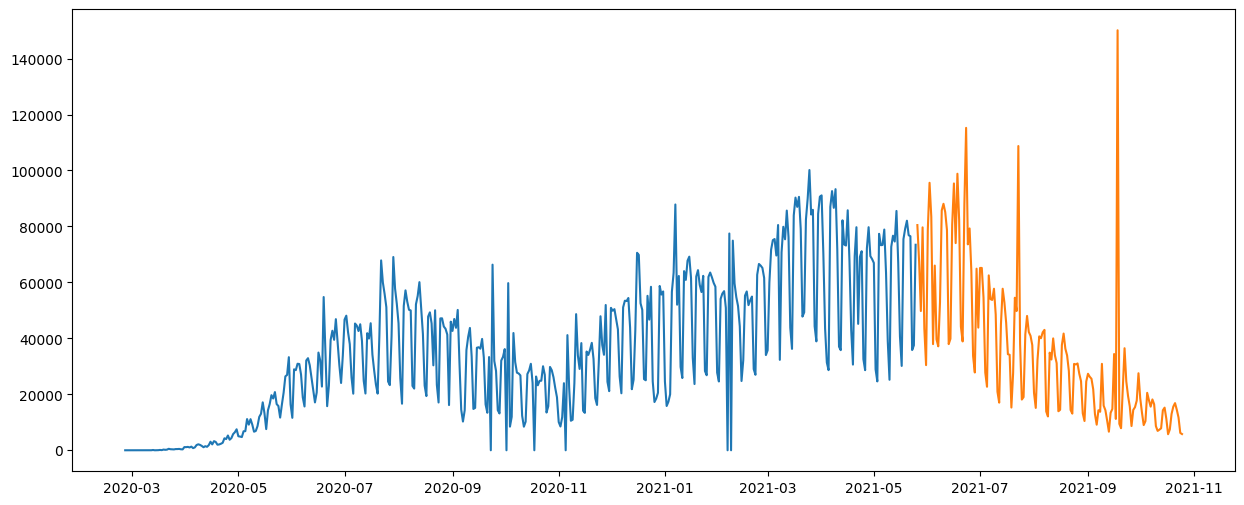

In [10]:
  train_size = int(len(df) * 0.75)
  test_size = len(df) - train_size
  train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
  print(len(train), len(test))
  plt.plot(train); plt.plot(test)

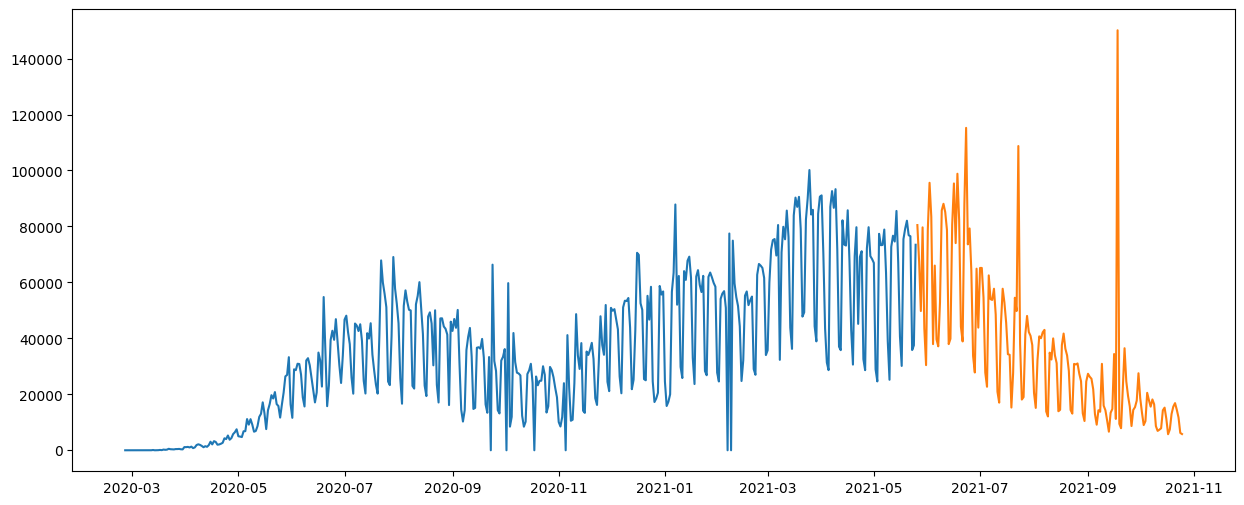

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, shuffle=False)
plt.plot(train); plt.plot(test)

# shufflebool, default=True: Whether or not to shuffle the data before splitting.

##### Normalização MinMax [0, 1]

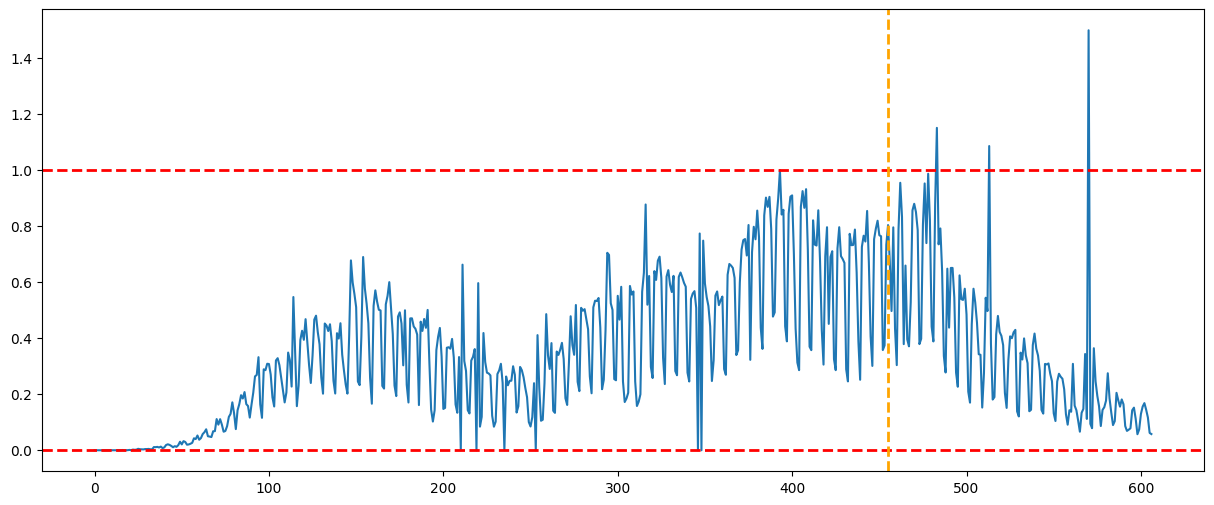

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train)  # fit considerando o conjunto de treinamento
train_norm = scaler.transform(train)
test_norm = scaler.transform(test)
#plt.plot(train_norm)
plt.plot(np.concatenate([train_norm, test_norm]))
plt.axhline(y=1.0, c="r", linewidth=2, linestyle = '--')
plt.axhline(y=0.0, c="r", linewidth=2, linestyle = '--')
plt.axvline(x=len(train), c="orange", linewidth=2, linestyle = '--')

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generatorTrain = TimeseriesGenerator(np.array(train_norm), np.array(train_norm), length=n_input, batch_size=1)
generatorTest = TimeseriesGenerator(np.array(test_norm), np.array(test_norm), length=n_input, batch_size=1)

#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator

In [14]:
#generatorTrain[0]
print(test_norm[0:13])
generatorTest[0]

[[0.80359033]
 [0.6736057 ]
 [0.49689491]
 [0.7954432 ]
 [0.43451347]
 [0.3038599 ]
 [0.78801494]
 [0.95450189]
 [0.8325945 ]
 [0.37876156]
 [0.65912858]
 [0.39574472]
 [0.37097386]]


(array([[[0.80359033],
         [0.6736057 ],
         [0.49689491],
         [0.7954432 ],
         [0.43451347],
         [0.3038599 ],
         [0.78801494],
         [0.95450189],
         [0.8325945 ],
         [0.37876156],
         [0.65912858],
         [0.39574472]]]),
 array([[0.37097386]]))

#### Vanilla LSTM

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

In [18]:
epochs = 300
n_neurons = 250
act_function = 'relu'
optimizer = 'adam'
loss = 'mse'

# Definindo modelo
tf.random.set_seed(42)
lstm_model = Sequential()


lstm_model.add(LSTM(n_neurons, activation=act_function, input_shape=(n_input, n_features)))

lstm_model.add(Dense(1))

# Compile e Fit do modelo
lstm_model.compile(optimizer=optimizer, loss=loss)
lstm_model.fit(generatorTrain, epochs=epochs, batch_size=1, shuffle=False)

Epoch 1/300
443/443 [==============================] - 17s 25ms/step - loss: 0.0250
Epoch 2/300
443/443 [==============================] - 12s 27ms/step - loss: 0.0269
Epoch 3/300
443/443 [==============================] - 10s 23ms/step - loss: 0.0257
Epoch 4/300
443/443 [==============================] - 11s 24ms/step - loss: 0.0238
Epoch 5/300
443/443 [==============================] - 13s 29ms/step - loss: 0.0262
Epoch 6/300
443/443 [==============================] - 11s 24ms/step - loss: 0.0244
Epoch 7/300
443/443 [==============================] - 10s 23ms/step - loss: 0.0207
Epoch 8/300
443/443 [==============================] - 12s 27ms/step - loss: 0.0176
Epoch 9/300
443/443 [==============================] - 11s 24ms/step - loss: 0.0170
Epoch 10/300
443/443 [==============================] - 13s 30ms/step - loss: 0.0165
Epoch 11/300
443/443 [==============================] - 12s 26ms/step - loss: 0.0168
Epoch 12/300
443/443 [==============================] - 12s 27ms/step - lo

140/140 [==============================] - 1s 4ms/step


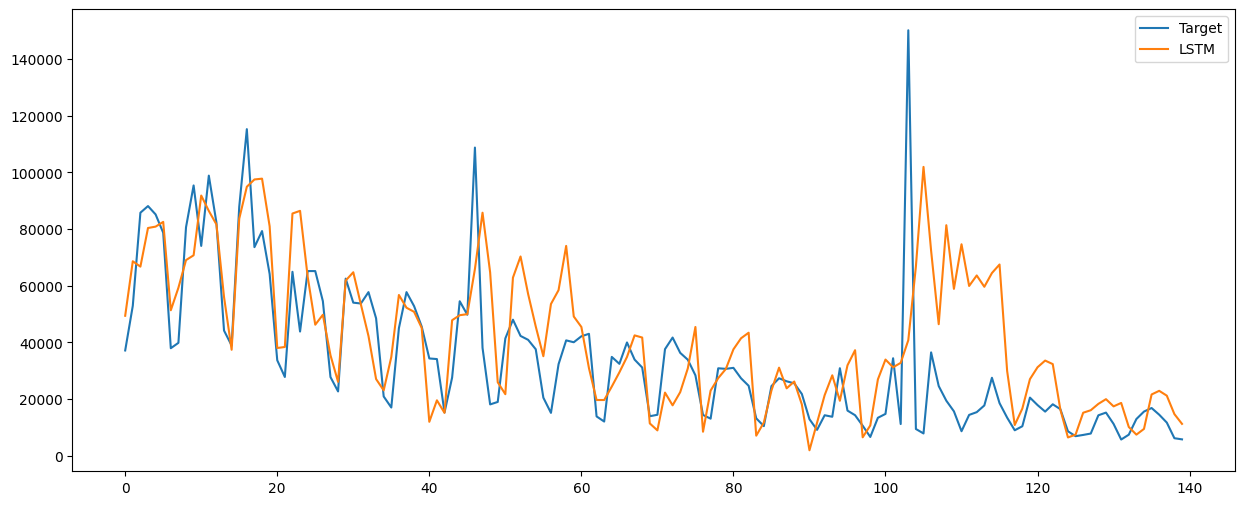

In [19]:
pred = lstm_model.predict(generatorTest)

predictions_actual = scaler.inverse_transform(pred)
test_target_actual = np.array(test[(n_input):])

plt.plot(test_target_actual, label="Target")
plt.plot(predictions_actual, label="LSTM")
plt.legend()

In [20]:
from sklearn.metrics import median_absolute_error, mean_squared_error

results = {}
print('LSTM results')
results['LSTM'] = {'rmse': round(mean_squared_error(test_target_actual, predictions_actual, squared=False), 2),
                  'mae': round(median_absolute_error(test_target_actual, predictions_actual), 2)}

pd.DataFrame(results)

LSTM results


,LSTM
mae,10576.51
rmse,22982.75
